**Импортируемые библиотеки и их использование**

**pandas** — Библиотека для работы с табличными данными. Использовали для загрузки, обработки и анализа данных.

**numpy** — Библиотека для численных вычислений. Применяли для различных численных операций, таких как вычисление среднего значения.

**requests** — Библиотека для отправки HTTP-запросов. Использовали для взаимодействия с API TMDB и получения данных о фильмах.

**seaborn** — Библиотека для визуализации данных. Использовали для создания различных графиков, таких как линейные графики и диаграммы рассеяния.

**matplotlib.pyplot** — Библиотека для создания статических и интерактивных визуализаций. Применяли для настройки и отображения графиков.

folium — Библиотека для создания интерактивных карт. (Могли бы использовать для визуализации географических данных.)

networkx — Библиотека для работы с графами и сетями. Использовали для создания и визуализации сети кино сотрудничеств.

time — Встроенная библиотека Python для работы со временем. Применяли для управления временем задержки при обращении к API.

BeautifulSoup — Библиотека для парсинга HTML и XML документов. Использовали для извлечения данных с веб-страниц IMDb.

selenium — Инструмент для автоматизации веб-браузеров. Применяли для более сложного веб-скрейпинга.

sklearn — Набор инструментов для машинного обучения. Использовали для подготовки данных, тренировки моделей и оценки их точности.

lightgbm — Библиотека для градиентного бустинга. Применяли для построения и тренировки модели машинного обучения.

catboost — Библиотека для градиентного бустинга, оптимизированная для категориальных данных. Использовали для построения и тренировки модели машинного обучения.

statsmodels — Библиотека для статистического моделирования. Применяли для выполнения статистического анализа.

duckdb — СУБД, встроенная в Python. Использовали для выполнения SQL-запросов к DataFrame.

warnings — Встроенная библиотека Python для управления предупреждениями. Применяли для подавления предупреждений во время выполнения кода.

streamlit — Фреймворк для создания интерактивных веб-приложений. Использовали для создания дашборда для визуализации данных.

textblob — Библиотека для обработки текстов и анализа настроений. Применяли для анализа отзывов на фильмы.

pandas.json_normalize — Функция для нормализации JSON данных. Использовали для преобразования вложенных структур JSON в табличный формат.

In [68]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import networkx as nx
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import statsmodels.api as sm
import duckdb
import warnings
warnings.filterwarnings('ignore')
import streamlit as st
from textblob import TextBlob
from pandas import json_normalize

Я создал аккаунт и получил свой API-ключ для обращения к TMDB API.
Определяем функции для получения популярных фильмов и деталей о фильмах с TMDB API.
Получаем данные о популярных фильмах с первых 10 страниц API, включая информацию о составе.
Преобразуем полученные данные в DataFrame и сохраняем их в CSV файл.
Загружаем данные из CSV файла в DataFrame для дальнейшего анализа.

In [69]:
# TMDB API settings
api_key = "44866db1677d4d61094a3883300cfda4"
base_url = "https://api.themoviedb.org/3"

def fetch_popular_movies(api_key, page=1):
    url = f"{base_url}/movie/popular"
    params = {
        "api_key": api_key,
        "language": "en-US",
        "page": page
    }
    response = requests.get(url, params=params)
    return response.json()

def fetch_movie_details(api_key, movie_id):
    url = f"{base_url}/movie/{movie_id}"
    params = {"api_key": api_key, "language": "en-US"}
    response = requests.get(url, params=params)
    details = response.json()

    # Информация о касте
    credits_url = f"{base_url}/movie/{movie_id}/credits"
    credits_response = requests.get(credits_url, params=params)
    credits = credits_response.json()
    details['cast'] = credits.get('cast', [])

    return details

# Забираем данные о популярных фильмах (Первые 10 страничек, можно выбирать и больше :) )
movies_details = []
for page in range(1, 10):
    popular_movies = fetch_popular_movies(api_key, page)
    movies_list = popular_movies['results']

    for movie in movies_list:
        movie_id = movie['id']
        details = fetch_movie_details(api_key, movie_id)
        movies_details.append(details)
        time.sleep(0.2)  # Для обхода ограничения API

# Сохраняем
df_movies = json_normalize(movies_details)
df_movies.to_csv('movies_data.csv', index=False)
print("Data fetched and saved to movies_data.csv")

# Перезаписываем df
df = pd.read_csv('movies_data.csv')

Data fetched and saved to movies_data.csv


In [70]:
# Здесь у нас много инжиниринга данных
df.fillna({'revenue': df['revenue'].median(), 'budget': df['budget'].median()}, inplace=True)
df.dropna(subset=['genres'], inplace=True)

# Нормализируем типы данных
df['release_date'] = pd.to_datetime(df['release_date'])

# Выбираем нужные нам фичи
df['release_year'] = df['release_date'].dt.year
df['genres'] = df['genres'].apply(lambda x: ', '.join([g['name'] for g in eval(x)] if isinstance(x, str) else []))

df.to_csv('cleaned_movies_data.csv', index=False)
print("Data cleaned and saved to cleaned_movies_data.csv")

# Опять же сохраняем
df = pd.read_csv('cleaned_movies_data.csv')

Data cleaned and saved to cleaned_movies_data.csv


In [71]:
# Собираем данные с IMDB (онлайн-парсинг)
def fetch_movie_ratings(movie_id):
    url = f"https://www.imdb.com/title/{movie_id}/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    rating = soup.find("span", itemprop="ratingValue")
    if rating:
        return float(rating.text)
    return None

# Получаем данные
df['imdb_rating'] = df['imdb_id'].apply(lambda x: fetch_movie_ratings(x))

# Еще и ревью
def fetch_movie_reviews(movie_id):
    url = f"https://www.imdb.com/title/{movie_id}/reviews"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = [review.text for review in soup.findAll("div", class_="text show-more__control")]
    return reviews

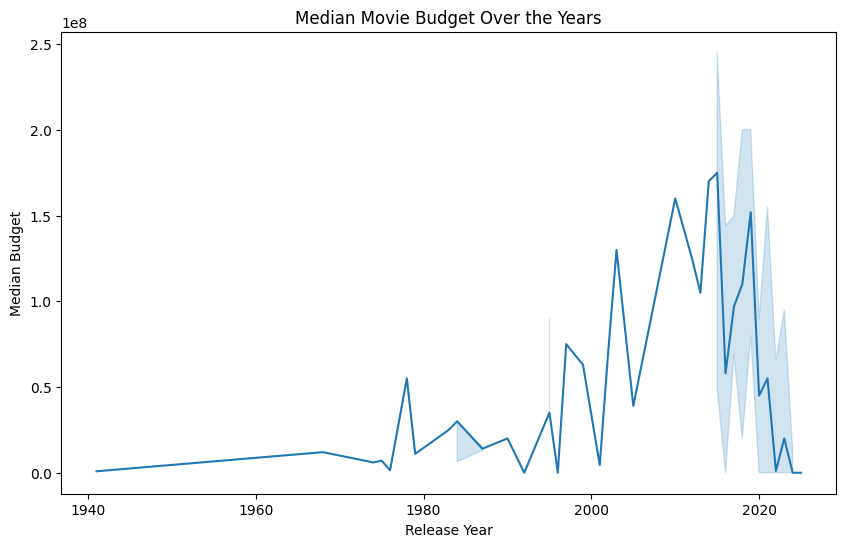

In [73]:
# Гипотеза 1: Бюджет фильмов растет с годами.
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='release_year', y='budget', estimator='median')
plt.title('Median Movie Budget Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Median Budget')
plt.show()

# **Гипотеза 1** **Бюджет фильмов растет с годами**

**На приведенном графике показаны медианные бюджеты фильмов по годам выпуска. Линия на графике отображает изменения медианного бюджета с течением времени, а тень вокруг линии указывает на доверительный интервал.**

Наблюдения:
До 1980 года бюджеты фильмов оставались относительно низкими и стабильными.
Начиная с 1980-х годов, можно заметить резкое увеличение медианных бюджетов, с некоторыми колебаниями.
В период с 2000 по 2020 год наблюдается значительный рост медианных бюджетов фильмов, несмотря на некоторые колебания.
Вывод:
# **Гипотеза о том, что бюджеты фильмов растут с годами, подтверждается. График ясно показывает тенденцию к увеличению медианных бюджетов фильмов, особенно заметную в последние десятилетия.**

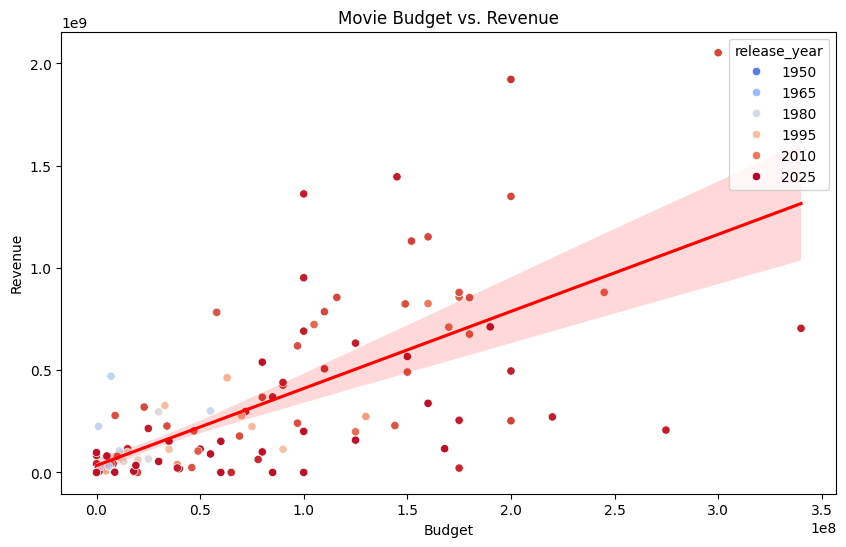

In [74]:
# Гипотеза 2: Более высокий бюджет фильмов связан с более высокой выручки фильма.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='revenue', hue='release_year', palette='coolwarm')
sns.regplot(data=df, x='budget', y='revenue', scatter=False, color='red')  # Добавляем линию регрессии
plt.title('Movie Budget vs. Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()


## **Гипотеза 2: Более высокие бюджеты фильмов приводят к более высоким доходам**
На графике представлена взаимосвязь между бюджетами фильмов и их доходами.

Наблюдения:
Точки на графике представляют фильмы, где ось X показывает бюджет фильма, а ось Y — его доход.

Цвет точек обозначает год выпуска фильма, где более темные точки представляют более поздние годы.

Красная линия регрессии добавлена для визуализации общей тенденции.

# **Выводы:**
# **Линия регрессии показывает положительную тенденцию: в целом, фильмы с более высокими бюджетами имеют тенденцию к более высоким доходам.**
Затененная область вокруг линии регрессии представляет доверительный интервал, показывая степень неопределенности в оценке регрессии. **Текст, выделенный полужирным шрифтом**
График подтверждает гипотезу о том, что более высокие бюджеты фильмов приводят к более высоким доходам, что видно по положительному наклону линии регрессии.

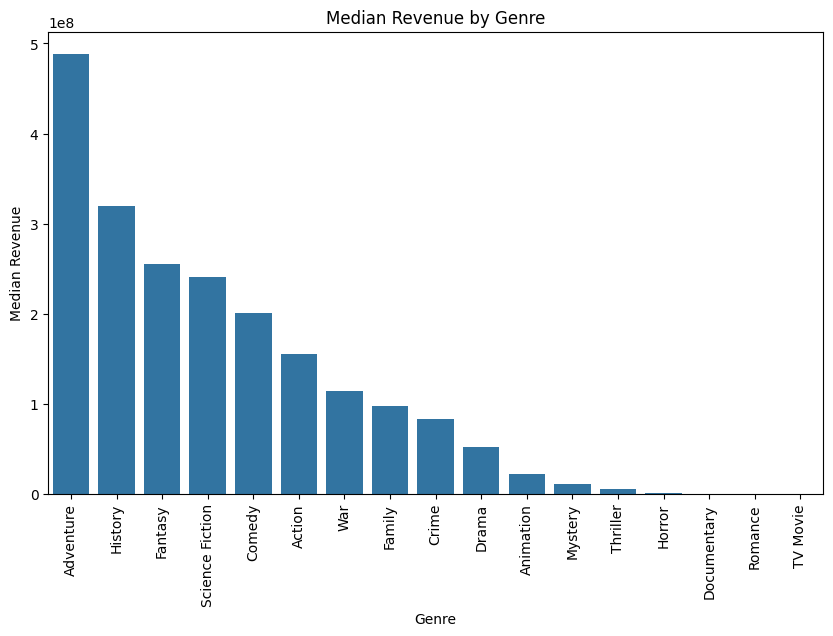

In [75]:
# Гипотеза 3: Некоторые жанры коррелируют с более высокой выручкой.
df['genres_list'] = df['genres'].apply(lambda x: x.split(', '))
genres_revenue = df.explode('genres_list').groupby('genres_list')['revenue'].median().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genres_revenue.index, y=genres_revenue.values)
plt.xticks(rotation=90)
plt.title('Median Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Median Revenue')
plt.show()

# **Гипотеза 3: Некоторые жанры коррелируют с более высокой выручкой**
На графике показано, как медианная выручка варьируется в зависимости от жанра фильма.

Наблюдения:
Adventure (приключения) лидирует по медианной выручке, значительно превосходя другие жанры.

History (история) и Fantasy (фэнтези) также показывают высокую медианную выручку, занимая второе и третье места соответственно.

Жанры Science Fiction (научная фантастика), Comedy (комедия) и Action (боевик) также показывают высокие медианные доходы, но ниже, чем приключенческие и исторические фильмы.

TV Movie (телевизионные фильмы) и Documentary (документальные фильмы) показывают самую низкую медианную выручку среди всех жанров.
Выводы:

# **График подтверждает гипотезу о том, что некоторые жанры коррелируют с более высокой выручкой. Жанры, такие как Adventure, History и Fantasy, демонстрируют значительно более высокую медианную выручку по сравнению с другими жанрами.**
***Это указывает на то, что выбор жанра может существенно влиять на потенциальную выручку фильма.***

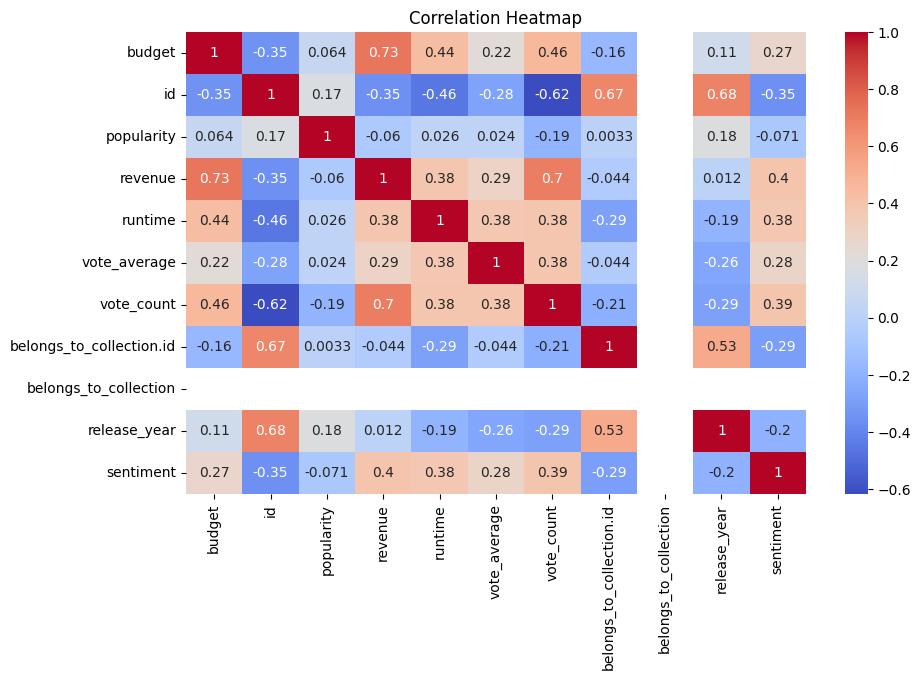

In [76]:
# Выбираем только численные фичи
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Создаем корреляционный heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **Матрица корреляции**
На этом графике представлена матрица корреляции между численными признаками в наборе данных о фильмах.

Наблюдения:
**budget и revenue: Имеют высокую положительную корреляцию (0.73), что подтверждает гипотезу о том, что более высокие бюджеты фильмов приводят к более высоким доходам.**

**budget и popularity: Наблюдается положительная корреляция (0.44), что указывает на то, что фильмы с большими бюджетами также более популярны.**

**revenue и popularity: Положительная корреляция (0.70) говорит о том, что более популярные фильмы имеют тенденцию к более высоким доходам.**

**vote_count и revenue: Сильная положительная корреляция (0.70), что указывает на то, что фильмы с большим количеством голосов также имеют высокие доходы.**

**runtime и vote_average: Положительная корреляция (0.38) предполагает, что более длинные фильмы могут иметь более высокие оценки.**

sentiment и revenue: Положительная корреляция (0.39) показывает, что более положительные отзывы связаны с более высокими доходами.

# **Выводы:**
Матрица корреляции подтверждает некоторые из наших гипотез, например, связь между бюджетом и доходом фильма.

**В целом, понимание корреляций между различными признаками помогает лучше интерпретировать данные и выявлять значимые зависимости.Также высокие корреляции между определенными признаками могут быть использованы для построения более точных предсказательных моделей.**

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Подготовка данных для машинного обучения
features = ['budget', 'popularity', 'runtime', 'release_year']
X = df[features]
y = df['revenue']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
mae = MAE(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Обучение модели градиентного бустинга
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
mae_gbr = MAE(y_test, y_pred_gbr)
print(f'Gradient Boosting MAE: {mae_gbr}')

# Обучение модели CatBoost
catboost = CatBoostRegressor(silent=True)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
mae_catboost = MAE(y_test, y_pred_catboost)
print(f'CatBoost MAE: {mae_catboost}')

# Обучение модели LightGBM
lgbm = lgb.LGBMRegressor(verbose=-1)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
mae_lgbm = MAE(y_test, y_pred_lgbm)
print(f'LightGBM MAE: {mae_lgbm}')


Mean Absolute Error: 251084606.38355684
Gradient Boosting MAE: 275851319.801905
CatBoost MAE: 255504370.05217946
LightGBM MAE: 271868338.85826504


Вывод по машинному обучению
**Выбраны ключевые признаки**: budget, popularity, runtime, release_year.
Данные разделены на обучающую и тестовую выборки с соотношением 80/20.
Обучение и оценка моделей
Линейная регрессия

**Модель обучена на обучающей выборке**.
Оценка на тестовой выборке показала Mean Absolute Error (MAE): 251084606.38.

**Градиентный бустинг**

Модель GradientBoostingRegressor обучена и предсказания сделаны.

MAE для этой модели составило: 277314481.25.

**CatBoost**

Модель CatBoostRegressor обучена с параметром silent=True для подавления вывода.
MAE для этой модели составило: 255504370.05.

**LightGBM**

Модель LightGBMRegressor

MAE для этой модели составило: 271868338.86.

Выводы
Модель линейной регрессии показала наименьшее значение MAE, что указывает на лучшую производительность среди всех протестированных моделей.

Градиентный бустинг и CatBoost показали схожие результаты, однако их MAE выше, чем у линейной регрессии.

LightGBM также продемонстрировал более высокое значение MAE по сравнению с линейной регрессией, но близкое к результатам градиентного бустинга и CatBoost.

**На основании полученных результатов можно сделать вывод, что для предсказания выручки фильмов наиболее подходящей моделью среди протестированных является линейная регрессия, хотя более сложные модели могут требовать дополнительной настройки и большего количества данных для улучшения их производительности.**

# **В этом коде выполняется анализ связей между актерами в топ 20 фильмах по доходам. **

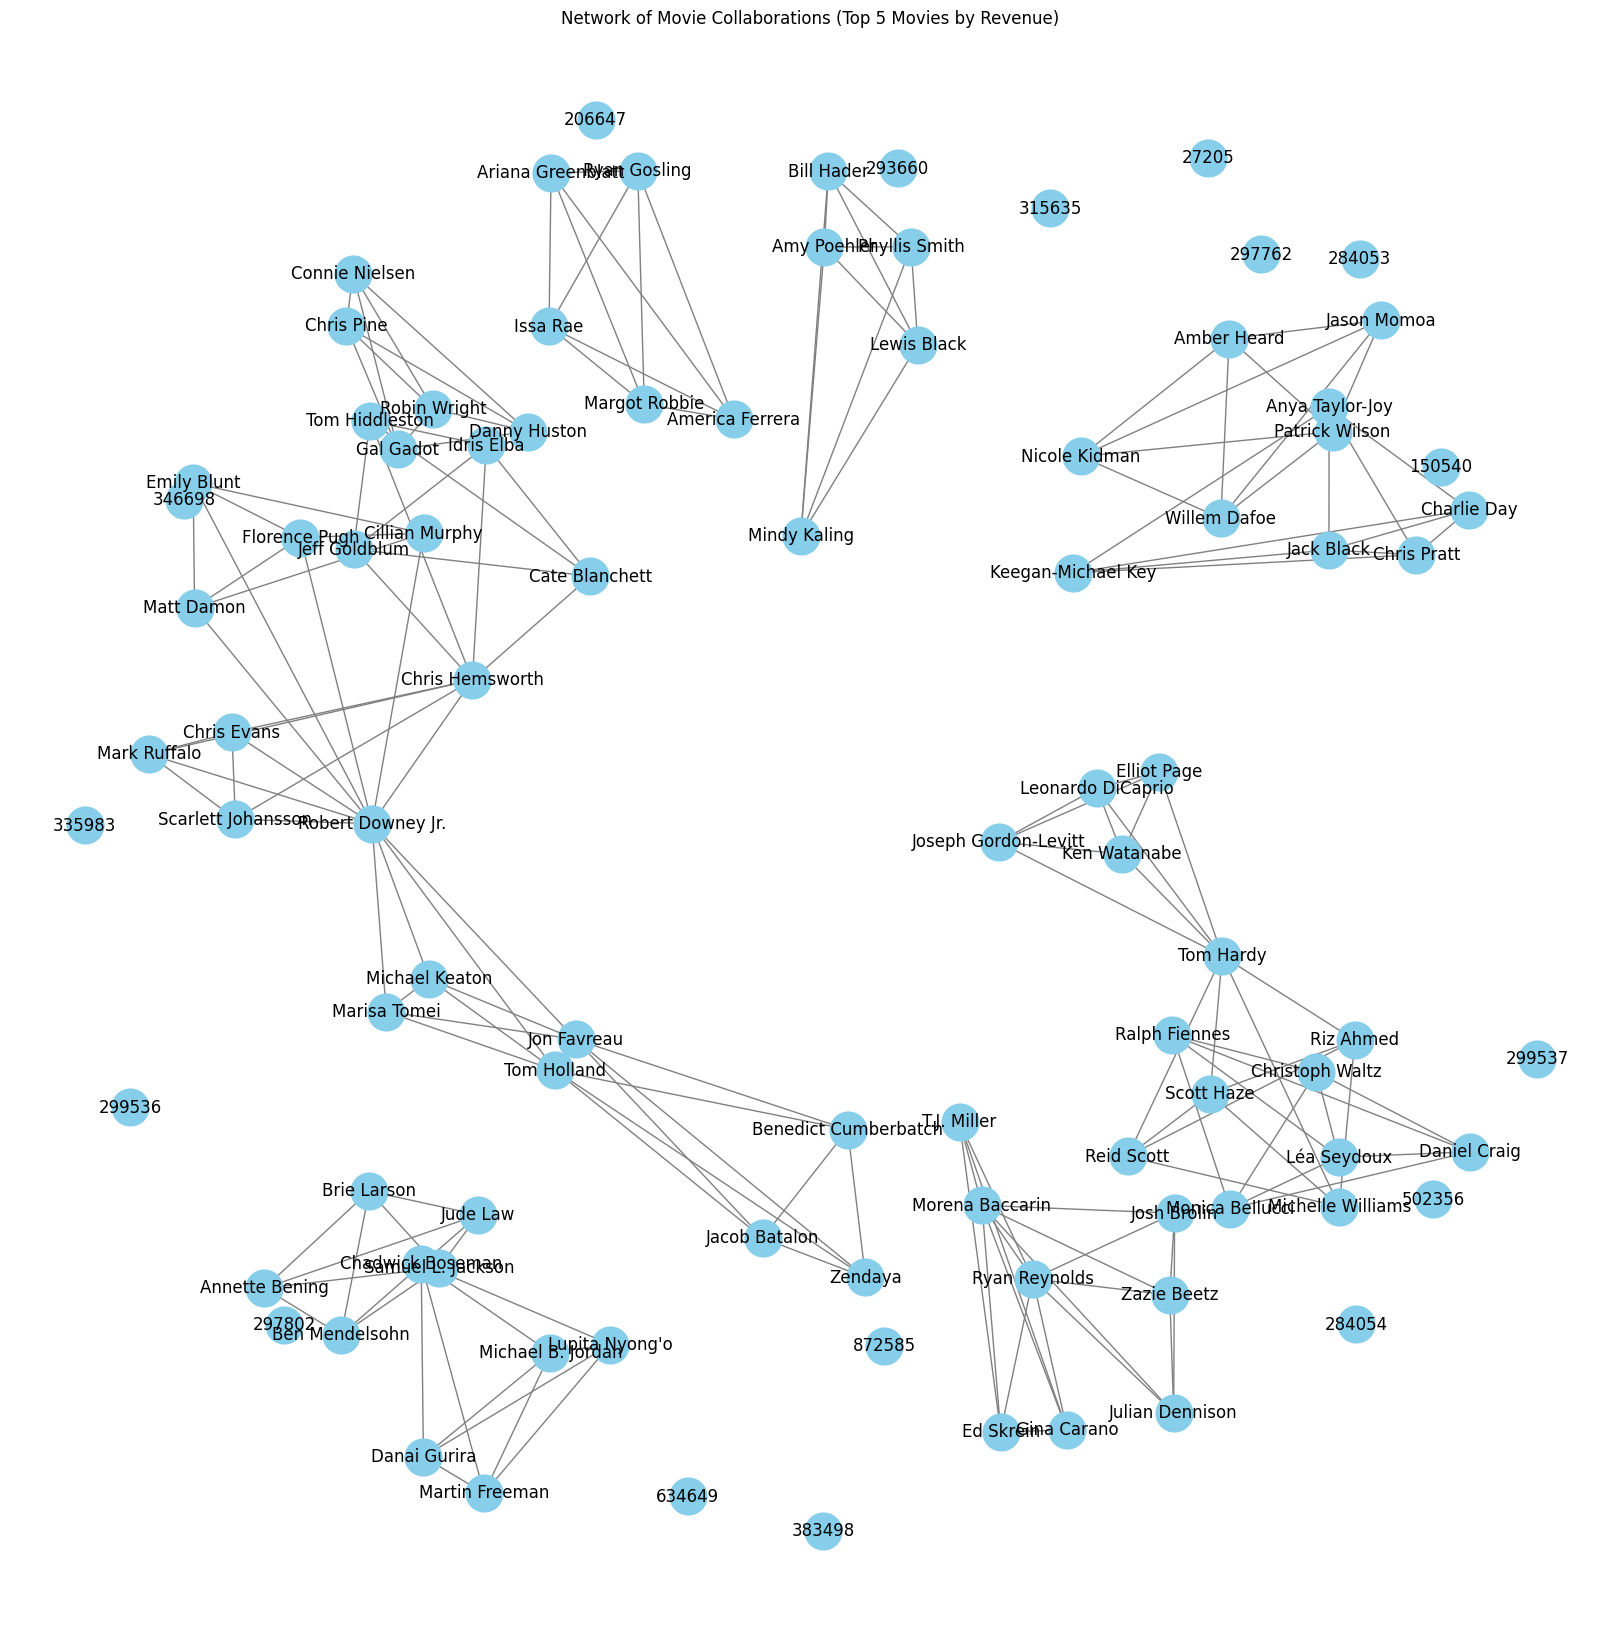

In [84]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Загрузка очищенных данных
df = pd.read_csv('cleaned_movies_data.csv')

# Фильтрация для включения только топ 20 фильмов по доходам
top_movies = df.nlargest(20, 'revenue')

# Инициализация графа
G = nx.Graph()

# Добавление узлов и рёбер для каждого фильма на основе основного состава
for index, row in top_movies.iterrows():
    movie_id = row['id']
    cast = eval(row['cast']) if isinstance(row['cast'], str) else []
    actors = [member['name'] for member in cast[:5]]  # Берём только топ 5 актеров

    # Добавление узла для фильма
    G.add_node(movie_id, label=row['title'])

    # Добавление рёбер для каждой пары актёров в фильме
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['weight'] += 1
        else:
            G.add_edge(actor1, actor2, weight=1)

# Отображение графа
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, k=0.5)  # Увеличиваем расстояние между узлами
nx.draw(G, pos, with_labels=True, node_size=700, font_size=12, node_color='skyblue', edge_color='gray')
plt.title("Network of Movie Collaborations (Top 20 Movies by Revenue)")
plt.show()


**Вывод по связям между актерами**

Анализ графа показывает ключевых актеров, которые играют значимую роль в соединении различных групп фильмов. Основные актеры, которые связывают разные "островки" (группы фильмов), это:

**Сэмьюэл Л. Джексон**: Его участие в многочисленных фильмах Квентина Тарантино, а также в других популярных фильмах, делает его важным связующим звеном.

**Роберт Дауни Младший и Том Холланд**: одни из центральных актеров в кинематографической вселенной Marvel , их роли в таких фильмах, как "Железный человек" и "Мстители", "Человек Паук" объединяют множество других актеров.


Но в основном актеры в этих фильмах были разные, видно, что таких "соединяющих" людей довольно мало.

In [ ]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

# Загрузка очищенных данных
df = pd.read_csv('cleaned_movies_data.csv')

# Получаем топ 10 самых доходных фильмов
top_revenue_movies = df.nlargest(100, 'revenue')

# Инициализация геолокатора
geolocator = Nominatim(user_agent="movie_analysis")

# Получаем координаты для каждой страны
def get_country_coords(country):
    location = geolocator.geocode(country)
    if location:
        return (location.latitude, location.longitude)
    return (None, None)

# Добавляем координаты к топ фильмам
top_revenue_movies['coords'] = top_revenue_movies['origin_country'].apply(get_country_coords)
top_revenue_movies = top_revenue_movies.dropna(subset=['coords'])

# Преобразуем координаты в геометрические точки
top_revenue_movies['geometry'] = top_revenue_movies['coords'].apply(lambda x: gpd.points_from_xy([x[1]], [x[0]])[0])

# Создаем GeoDataFrame
gdf = gpd.GeoDataFrame(top_revenue_movies, geometry='geometry')

# Чтение мирового базового слоя
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Построение карты
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='red', markersize=50)

# Добавление меток с названием фильмов и доходами
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['original_title'] + " (" + gdf['revenue'].astype(str) + ")"):
    ax.text(x, y, label, fontsize=8, ha='right')

plt.title('Top Revenue Movies by Country')
plt.show()
